In [1]:
##inspired from https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

# Time Series Forcasing With ARIMA & SARIMA

## Importing Libraries

In [9]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams

import warnings 
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [82]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])


In [84]:
df.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


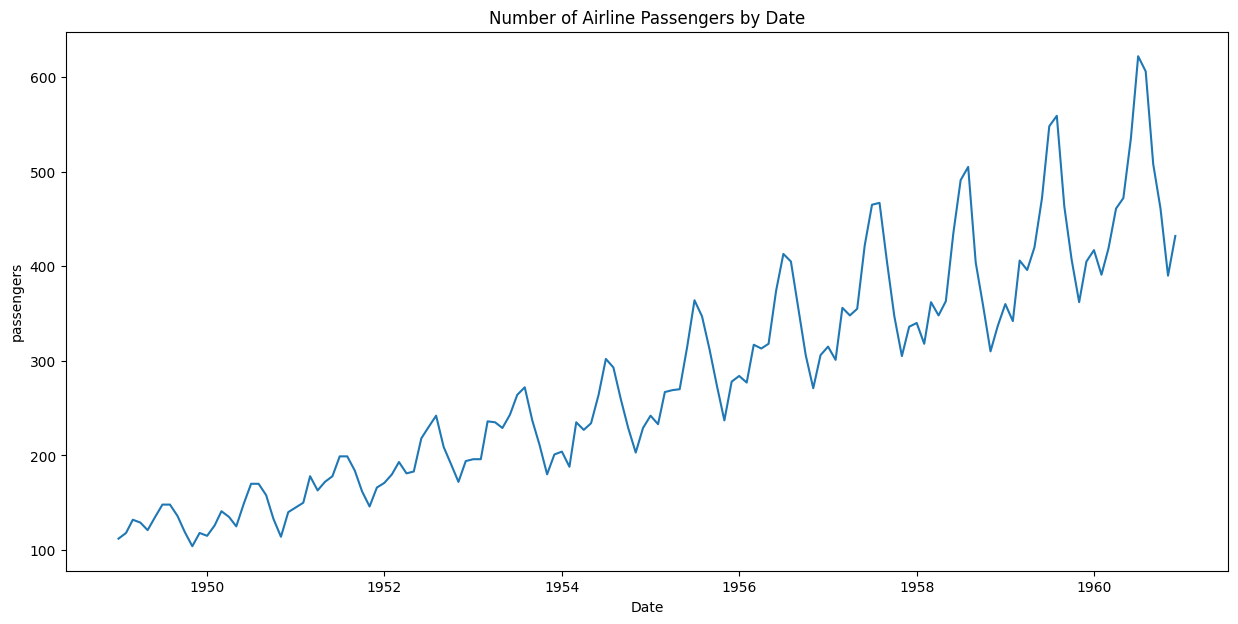

In [85]:
##lets plot some data

plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('passengers')
plt.plot(df)
plt.show()

### Rolling Statistics 

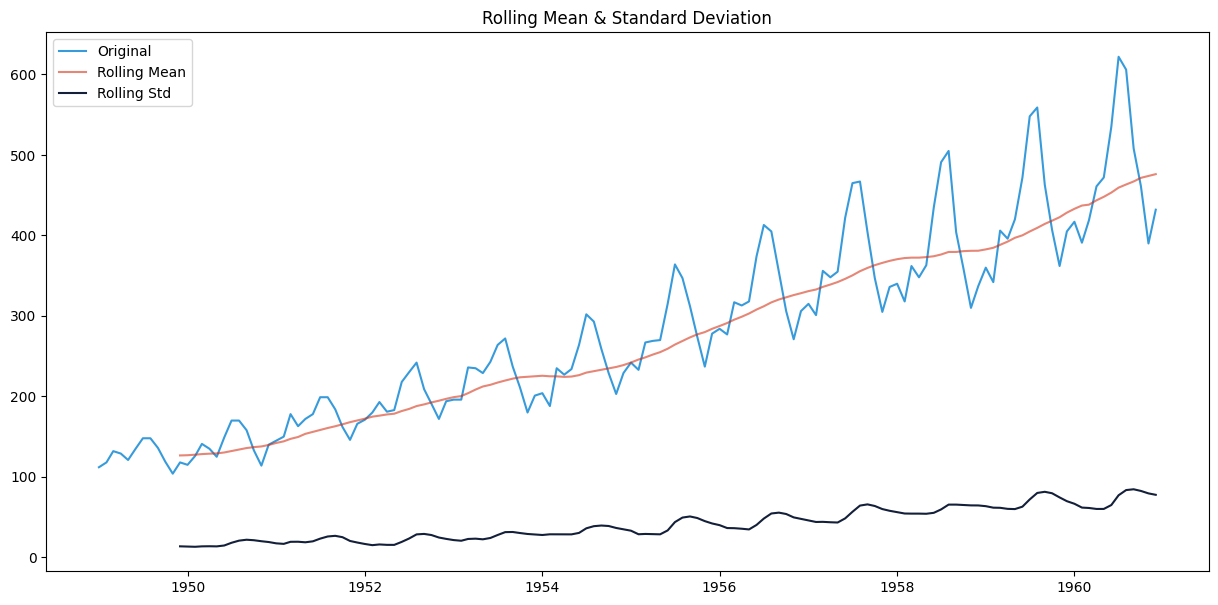

In [89]:
df['rolling_avg'] = df["#Passengers"].rolling(window=12).mean()
df['rolling_std'] = df["#Passengers"].rolling(window=12).std()

#plat rolling stattics
plt.figure(figsize=(15,7))
plt.plot(df['#Passengers'],color="#379BDB",label="Original")
plt.plot(df['rolling_avg'],color="#D22A0D90",label="Rolling Mean")
plt.plot(df['rolling_std'],color="#142039",label="Rolling Std")
plt.legend(loc='best')
plt.title("Rolling Mean & Standard Deviation")
plt.show(block=False)
                

## Augmented Dickey–Fuller Test

In [91]:
#test
print("Results of dickey fuller test:")
dftest = adfuller(df["#Passengers"],autolag="AIC")
dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','#No of obversation used'])

for key,value in dftest[4].items():
    dfoutput['Critical value (%s)'%key] = value
print(dfoutput)


Results of dickey fuller test:
Test Statistics              0.815369
p-value                      0.991880
#Lags Used                  13.000000
#No of obversation used    130.000000
Critical value (1%)         -3.481682
Critical value (5%)         -2.884042
Critical value (10%)        -2.578770
dtype: float64


In [94]:
dftest

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

### Standard Arima Model

In [95]:
ARIMA_model = pm.auto_arima(df['#Passengers'],start_p=1,start_q=1,test='adf',max_p=3,max_q=3,
                           m=1,d=None,seasonal=False,trace=False,error_action="warn",
                           suppress_warnings=True,stepwise=True
                           )

In [96]:
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -699.125
Date:                Sat, 17 Jun 2023   AIC                           1408.249
Time:                        14:10:46   BIC                           1423.098
Sample:                    01-01-1949   HQIC                          1414.283
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.6007     12.051      1.627      0.104      -4.018      43.219
ar.L1          0.4990      0.131      3.822      0.000       0.243       0.755
ar.L2          0.4314      0.124      3.466      0.0

### Model Diagnostics

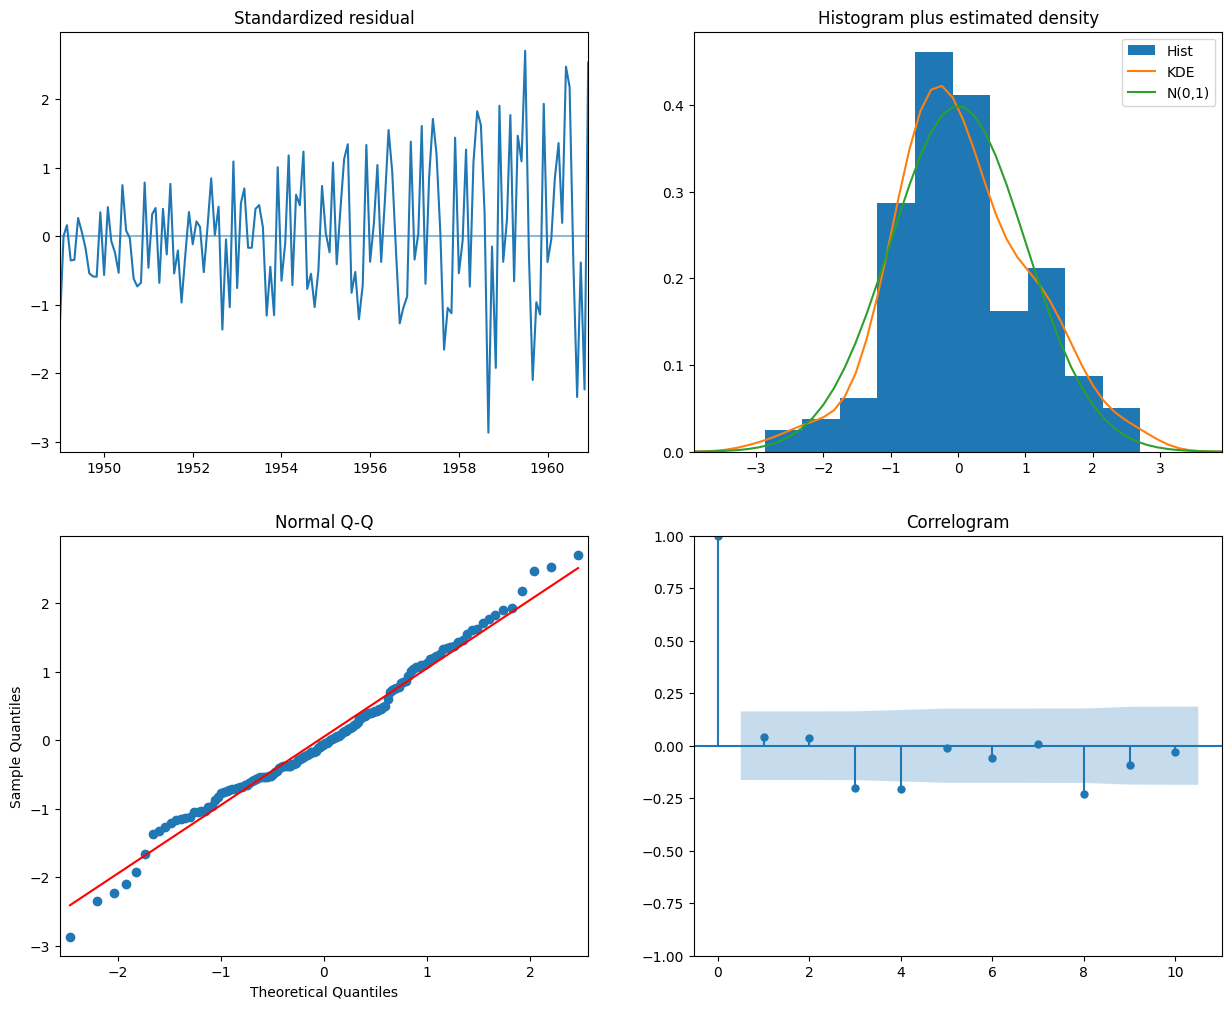

In [100]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()


### Let's do Forcast

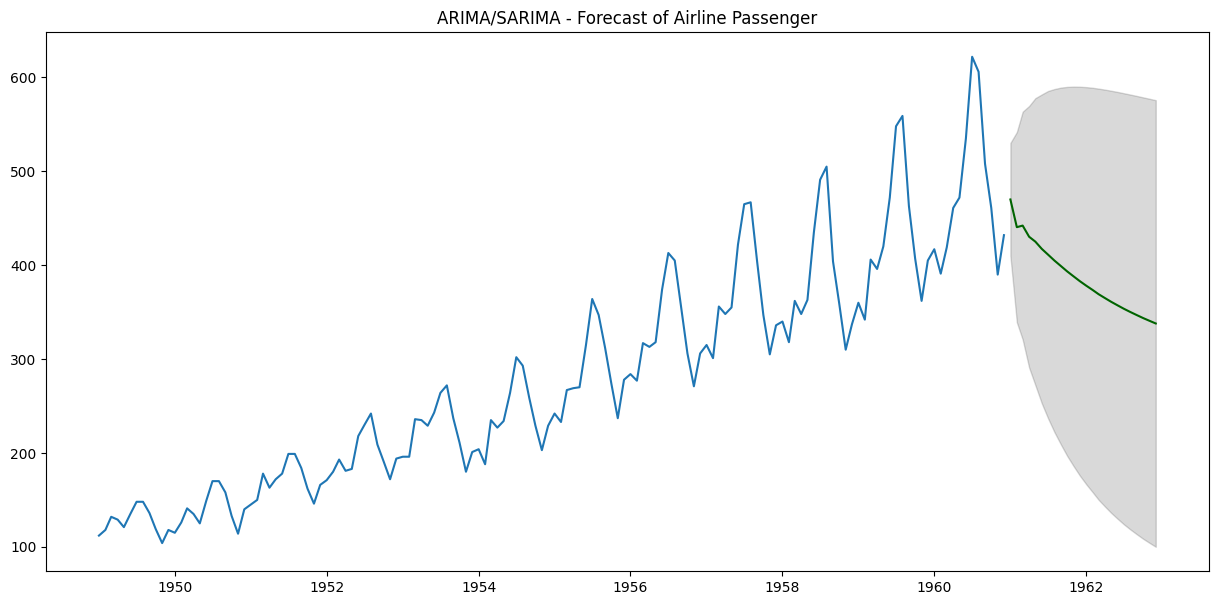

In [108]:
def forecast(ARIMA_model,periods=24):
    #Forecast
    n_periods = periods
    fitted,confint = ARIMA_model.predict(n_periods=n_periods,return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1]+pd.DateOffset(months=1),periods=n_periods,freq='MS')
    
    #makes series for plotting purpose
    fitted_series = pd.Series(fitted,index=index_of_fc)
    lower_series= pd.Series(confint[:,0],index=index_of_fc)
    upper_series = pd.Series(confint[:,1],index=index_of_fc)
    
    #plot
    plt.figure(figsize=(15,7))
    plt.plot(df['#Passengers'],color="#1f76b4")
    plt.plot(fitted_series,color="darkgreen")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k',alpha=.15           
                    )
    plt.title("ARIMA/SARIMA - Forecast of Airline Passenger")
    plt.show()
    
forecast(ARIMA_model)

## SARIMA Model 

In [109]:
SARIMA_model = pm.auto_arima(df["#Passengers"],start_p=1,start_q=1,
                            test='adf',
                            max_p=3,max_q=3,
                            m=12,
                            start_P=0,
                            seasonal=True,
                            d=None,
                            D=1,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

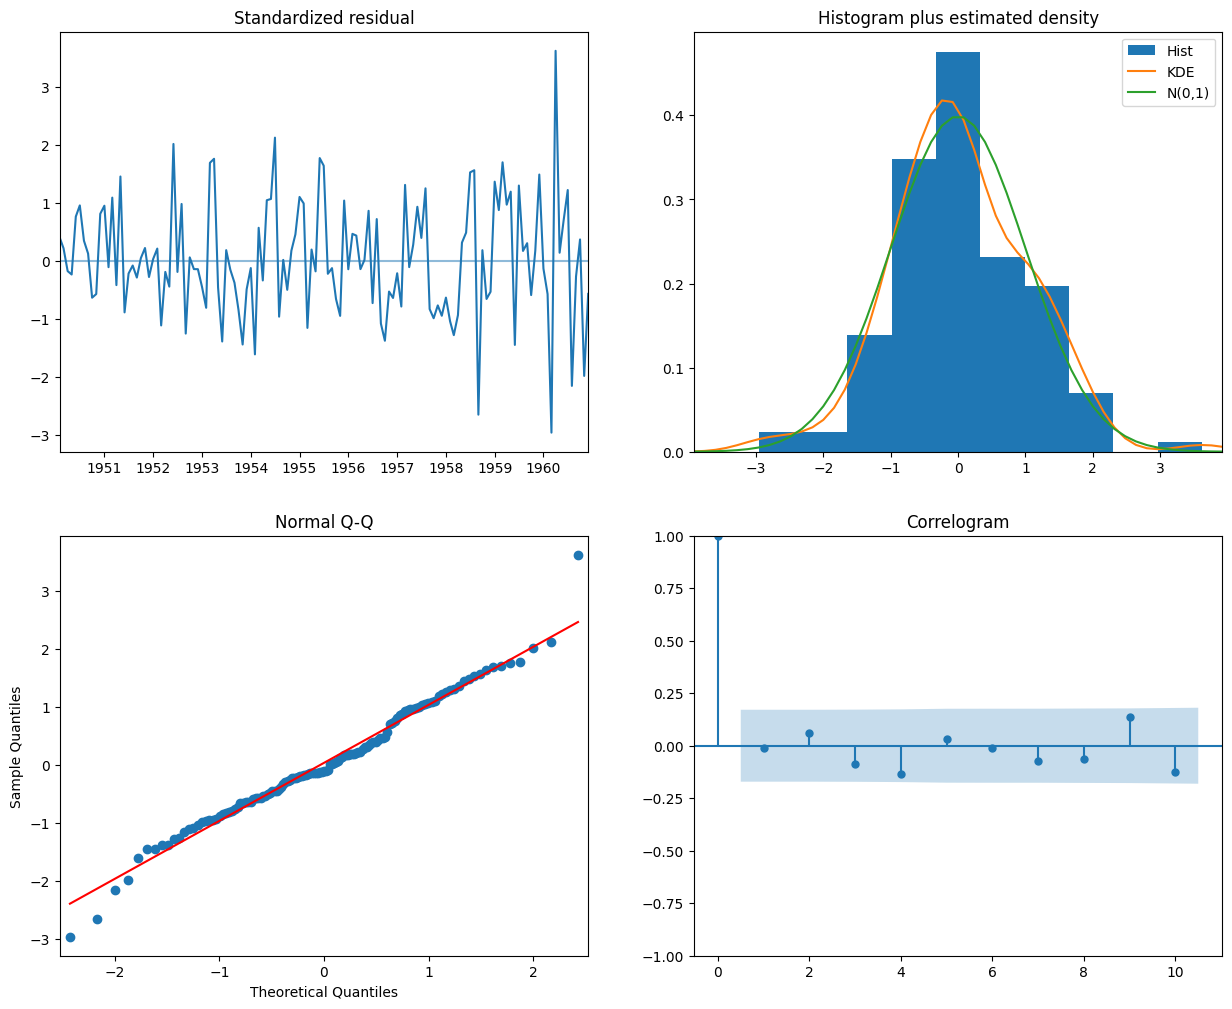

In [111]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

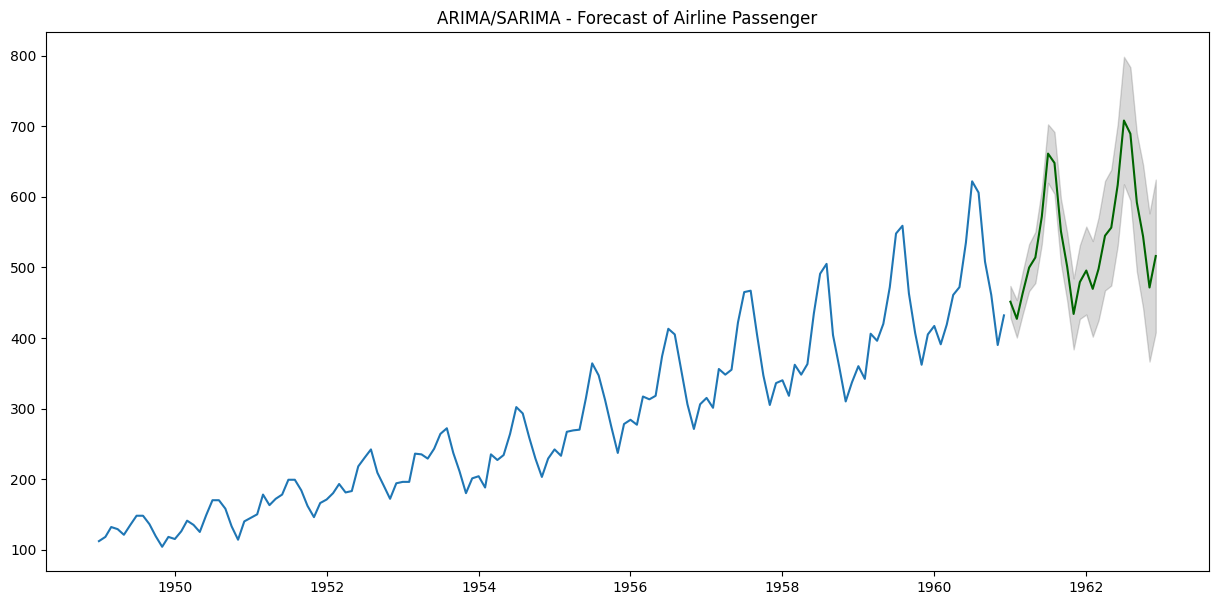

In [112]:
forecast(SARIMA_model)


## SARIMAX  

In [114]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sat, 17 Jun 2023   AIC                           1019.178
Time:                                     14:56:22   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

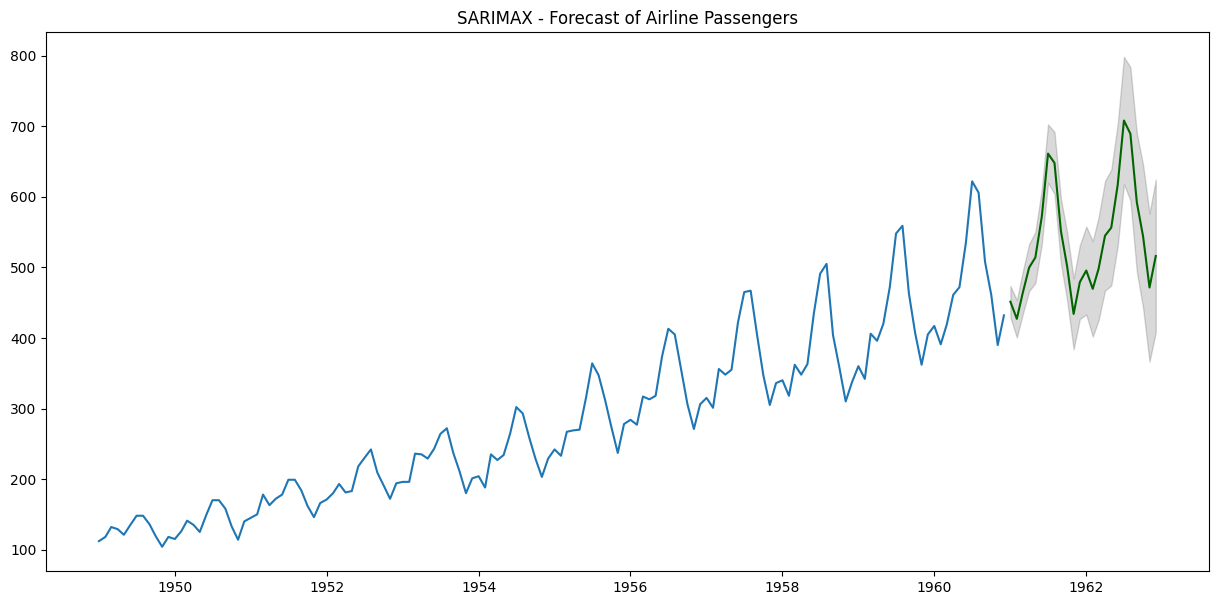

In [115]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1]+ pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

# further reading & Implementation
A Deep Dive on Arima Models https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf — by Matt Sosna ← MUST READ!

Time Series For beginners with ARIMA https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima/notebook  — by @Arindam Chatterjee

Arima Model for Time Series Forecasting https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting#14.-SARIMA-model-in-python- — by @Prashant Banerjee

StatsModels ADF Documentation https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html?highlight=augmented%20dickey%20fuller%20test

Removing Trends and Seasonality Article  https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/ — by Jason Brownlee

A Gentle Introduction to SARIMA  https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/ — by Jason Brownlee